In [1]:
###  RUN FROM SCRATCH  ### 

import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'


MODELS_DIR = '/home/ubuntu/surgery-tool-detection/models/'
LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

##MODELS_DIR = str(Path(__file__).resolve().parents[2]) + '/models/'
##LOGS_DIR = str(Path(__file__).resolve().parents[2]) + '/logs/'
# pretrained_model = MODELS_DIR + 'coco_resnet_50_map_0_335_state_dict.pt'

print('CUDA available: {}'.format(torch.cuda.is_available()))

print(MODELS_DIR) 

print(LOGS_DIR) 


### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

#parser = parser.parse_args(args)


##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = 'Augie' 
parser.depth = 50 
parser.epochs = 1 

#parser.sampler = None 
#parser.sampler = "old balanced (no alpha)" 
parser.sampler = 'new balanced' 

parser.alpha = 0.0 
parser.augment = 0.0 #False 
parser.pipeline = "lighting" #False 

##### END PRIMARY CONFIGS ######## 

parser.log_output = True 
LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.dataset = 'csv' 
parser.csv_train = '/home/ubuntu/surgery-tool-detection/src/data/train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/home/ubuntu/surgery-tool-detection/src/data/val_data.csv' #../val_data.csv 
parser.csv_classes = '/home/ubuntu/surgery-tool-detection/src/data/class_names.csv' #../data/class_names.csv 


parser.blacken = False 
parser.learning_rate = None 

parser.batch_size = None ## Set and log config? 
parser.threshold = None ## Set and log config? 




model_name = 'model'
if parser.model_name is not None:
    model_name = parser.model_name

learning_rate = 1e-5
if parser.learning_rate is not None:
    learning_rate = float(parser.learning_rate)

batch_size = 2
if parser.batch_size is not None:
    batch_size = int(parser.batch_size)

threshold = 0.5
if parser.threshold is not None:
    threshold = float(parser.threshold)

    
    
    
# Create the dataloaders     

if parser.dataset == 'coco':

    if parser.coco_path is None:
        raise ValueError('Must provide --coco_path when training on COCO,')

    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

elif parser.dataset == 'csv':

    if parser.csv_train is None:
        raise ValueError('Must provide --csv_train when training on COCO,')

    if parser.csv_classes is None:
        raise ValueError('Must provide --csv_classes when training on COCO,')

#     dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
#                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
#                                augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Resizer()]), blacken=parser.blacken)

    if parser.csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

else:
    raise ValueError('Dataset type not understood (must be csv or coco), exiting.')
    


sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)
if parser.sampler is not None and parser.sampler == 'old balanced (no alpha)':
    sampler = BalancedSampler(dataset_train, batch_size=batch_size, drop_last=False) 
if parser.sampler is not None and parser.sampler == 'new balanced': 
    class_indices_dict = aggregate_indices_per_class(dataset_train) 
    class_indices = list(class_indices_dict.values()) 
    # print(len(class_indices)) 
    # for label in class_indices: print(len(label))
    #batch_sz = 2 
    # print("Hello") 
    # print(len(dataset_train)//batch_sz) 
    sampler = SamplerFactory().get(
        class_idxs=class_indices,
        batch_size=batch_size,
        n_batches=len(dataset_train)//batch_size,
        alpha=parser.alpha,
        kind='random'
    ) 
    
    
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)



/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


CUDA available: True
/home/ubuntu/surgery-tool-detection/models/
/home/ubuntu/surgery-tool-detection/logs/
Using new Balanced Sampler


In [10]:

#print(dataset_train.image_names) 

# image_index = 0 
# annotation_list = dataset_train.image_data[dataset_train.image_names[image_index]] 
# print(dataset_train.image_names[image_index]) 
# print(annotation_list) 

#print(dataset_train.image_names) 

# filename = '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000737.jpg' 
# if filename in dataset_train.image_names: 
#     print(dataset_train.image_names.index(filename)) 



# def getfilename(filename): 
#     if filename in dataset_train.image_names: 
#         index = dataset_train.image_names.index(filename) 
#         sample = dataset_train[index] 
#         return sample 
    
# filename = '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000737.jpg' 
# sample = getfilename(filename) 
# print(sample) 


# index = dataset_train.getfilenameindex(filename) 
# sample = dataset_train[index] 
# print(sample) 

# for idx, filename in enumerate(dataset_train.image_names): 
#     if idx > 1: break 
#     index = dataset_train.image_names.index(filename) 
#     sample = dataset_train[index] 
#     print(filename) 
#     print(sample) 





# for idx, sample in enumerate(dataset_train): 
#     if idx > 1: break
#     #print(sample) 
    

# filename = 'd4-VN5A6_Ac-000000737.jpg' 

# #print(dataset_train[0]) 

# #print(dataset_train[0]['filename']) 

In [3]:

import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()

# print(len(dataset_train.image_data)) 
# print(len(dataset_val.image_data)) 

#print(len(dataset_train)) 

idx_to_filename_train = {} 

for idx, sample in enumerate(dataset_train): 
    filename = sample['filename'].rsplit('/',1)[1]  
    print(idx) 
    #print(filename) 
    idx_to_filename_train[filename] = idx 
    #if idx == 0: break 

idx_to_filename_val = {} 

for idx, sample in enumerate(dataset_val): 
    filename = sample['filename'].rsplit('/',1)[1]  
    print(idx) 
    #print(filename) 
    idx_to_filename_val[filename] = idx 
    #if idx == 0: break 
        
print(idx_to_filename_train) 
print(idx_to_filename_val) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


KeyboardInterrupt: 

In [11]:

print(idx_to_filename_train) 
print(idx_to_filename_val) 



{'dLap-hcBxc0-000000455.jpg': 0, 'dLap-hcBxc0-000000607.jpg': 1, 'dLap-hcBxc0-000000759.jpg': 2, 'dLap-hcBxc0-000000911.jpg': 3, 'dLap-hcBxc0-000001063.jpg': 4, 'dLap-hcBxc0-000001215.jpg': 5, 'dLap-hcBxc0-000001367.jpg': 6, 'dLap-hcBxc0-000001519.jpg': 7, 'dLap-hcBxc0-000001671.jpg': 8, 'dLap-hcBxc0-000001823.jpg': 9, 'dqVauLWgZ5k-000000869.jpg': 10, 'dqVauLWgZ5k-000001159.jpg': 11, 'dqVauLWgZ5k-000001449.jpg': 12, 'dqVauLWgZ5k-000001739.jpg': 13, 'dqVauLWgZ5k-000002029.jpg': 14, 'dqVauLWgZ5k-000002319.jpg': 15, 'dqVauLWgZ5k-000002609.jpg': 16, 'dqVauLWgZ5k-000002899.jpg': 17, 'dqVauLWgZ5k-000003189.jpg': 18, 'dqVauLWgZ5k-000003479.jpg': 19, 'e12tIDPDfwU-000001031.jpg': 20, 'e12tIDPDfwU-000001375.jpg': 21, 'e12tIDPDfwU-000001719.jpg': 22, 'e12tIDPDfwU-000002063.jpg': 23, 'e12tIDPDfwU-000002407.jpg': 24, 'e12tIDPDfwU-000002751.jpg': 25, 'e12tIDPDfwU-000003095.jpg': 26, 'e12tIDPDfwU-000003439.jpg': 27, 'e12tIDPDfwU-000003783.jpg': 28, 'e12tIDPDfwU-000004127.jpg': 29, 'fHZ_0htxQ4k-000002

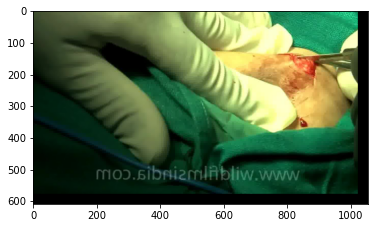

In [31]:

filename = 'BssDb0s5cdA-000000647.jpg' #'synW6molzgA-000005809.jpg' 


try: 
    idx = idx_to_filename_train[filename] 
    sample = dataset_train[idx] 
except: 
    idx = idx_to_filename_val[filename] 
    sample = dataset_val[idx] 

image = np.array(sample['img']) 
annots = np.array(sample['annot']) 


def draw_caption(image, box, caption): 
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        
for annot in annots:
    if annot[4] == -1: 
        continue 
    label_name = dataset_val.labels[annot[4]]
    print(label_name) 
    x1 = int(annot[0])
    y1 = int(annot[1])
    x2 = int(annot[2])
    y2 = int(annot[3])
    draw_caption(image, (x1, y1, x2, y2), label_name)
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  

plt.imshow(image) #[:, :, ::-1]) 
plt.show() 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


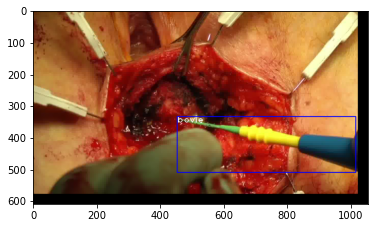

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


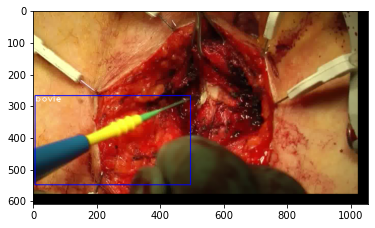

In [15]:
import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()


for idx, filename in enumerate(dataset_train.image_names): 
    if idx > 1: break 
    index = dataset_train.image_names.index(filename) ### 
    sample = dataset_train[index] ### These 2 lines go from a given filename to its sample annotations {,,...,} 
    #print(filename) 
    #print(sample) 
    image = np.array(sample['img']) 
    annots = np.array(sample['annot']) 

    def draw_caption(image, box, caption): 
        b = np.array(box).astype(int)
        cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        
    for annot in annots:
        if annot[4] == -1: 
            continue 
        label_name = dataset_val.labels[annot[4]] 
        x1 = int(annot[0])
        y1 = int(annot[1])
        x2 = int(annot[2])
        y2 = int(annot[3])
        draw_caption(image, (x1, y1, x2, y2), label_name)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
        
    plt.imshow(image) #[:, :, ::-1]) 
    plt.show()


In [27]:
      
    
# Do this for every image in the dataset_train, dataset_val, and dataset_test 
# Or just make a dataset from raw_data.csv and use that instead!! (Will contain all images) 
# But first setup the yes/no pipeline here... 

clean = [] 
bad = [] 

for idx, filename in enumerate(dataset_train.image_names): 
    if idx > 1: break 
    index = dataset_train.image_names.index(filename) 
    sample = dataset_train[index] 
    image = np.array(sample['img']) 
    annots = np.array(sample['annot']) 
    def draw_caption(image, box, caption): 
        b = np.array(box).astype(int)
        cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    for annot in annots:
        if annot[4] == -1: 
            continue 
        label_name = dataset_val.labels[annot[4]] 
        x1 = int(annot[0])
        y1 = int(annot[1])
        x2 = int(annot[2])
        y2 = int(annot[3])
        draw_caption(image, (x1, y1, x2, y2), label_name)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
        
    plt.imshow(image) 
    plt.show() 
    
    while True:
        answer = input("Clean? ") 
        if answer not in ("yes", "no"):
            print("Not an appropriate choice.") 
        else:
            break

    if answer == "yes": 
        clean.append(filename) 
    if answer == "no": 
        bad.append(filename) 
     
    from IPython.display import clear_output
    clear_output(wait=False)
    
        


In [34]:
      
    
# Do this for every image in the dataset_train, dataset_val, and dataset_test 
# Or just make a dataset from raw_data.csv and use that instead!! (Will contain all images) 
# But first setup the yes/no pipeline here... 

clean = [] 
bad = [] 


def displayFilenameAnnotations(filename): 
    index = dataset_train.image_names.index(filename) 
    sample = dataset_train[index] 
    image = np.array(sample['img']) 
    annots = np.array(sample['annot']) 
    def draw_caption(image, box, caption): 
        b = np.array(box).astype(int)
        cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    for annot in annots:
        if annot[4] == -1: 
            continue 
        label_name = dataset_val.labels[annot[4]] 
        x1 = int(annot[0])
        y1 = int(annot[1])
        x2 = int(annot[2])
        y2 = int(annot[3])
        draw_caption(image, (x1, y1, x2, y2), label_name)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
    plt.imshow(image) 
    plt.show() 
    

for idx, filename in enumerate(dataset_train.image_names): 
    if idx > 10: break 
    displayFilenameAnnotations(filename) 
    
    while True:
        answer = input("Clean? ") 
        if answer not in ("y", "n"):
            print("Not an appropriate choice.") 
        else:
            break

    if answer == "y": 
        clean.append(filename) 
    if answer == "n": 
        bad.append(filename) 
     
    from IPython.display import clear_output
    clear_output(wait=False)
    
        


In [36]:
print(len(clean)) 
print(len(bad))
print(len(clean) + len(bad)) 
print(clean) 
print(bad) 

5
6
11
['/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000737.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000000983.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001967.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002213.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002951.jpg']
['/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001229.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001475.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000001721.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002459.jpg', '/home/ubuntu/tools_data/data/images/d4-VN5A6_Ac-000002705.jpg', '/home/ubuntu/tools_data/data/images/dLap-hcBxc0-000000455.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clean


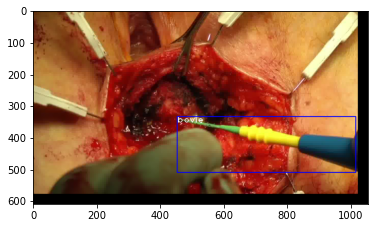

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clean


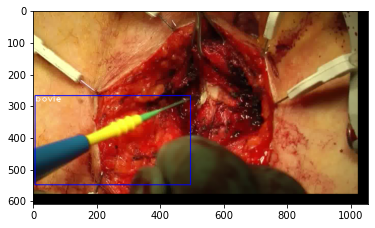

Clean


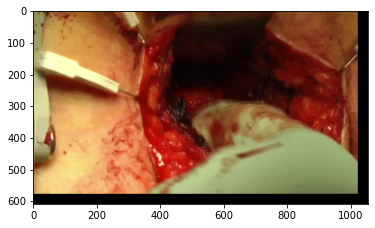

Clean


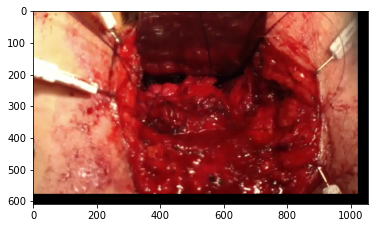

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clean


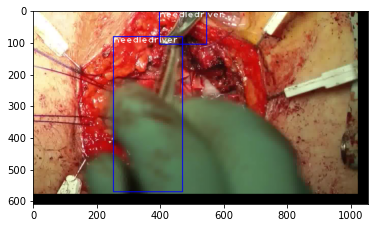

In [37]:
for filename in clean: 
    print("Clean") 
    displayFilenameAnnotations(filename) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bad


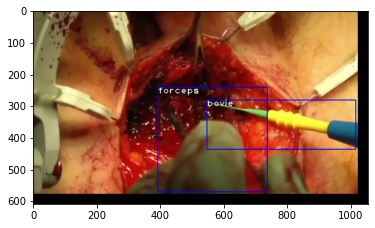

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bad


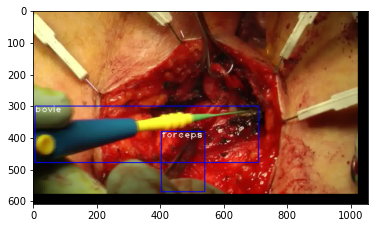

Bad


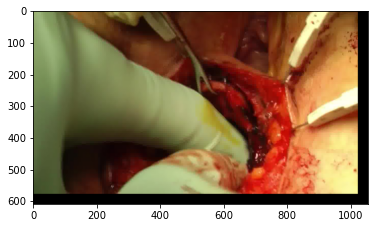

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bad


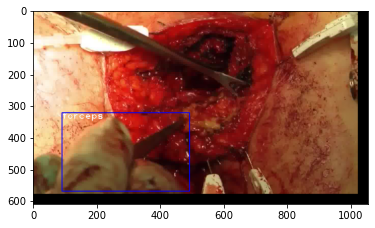

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bad


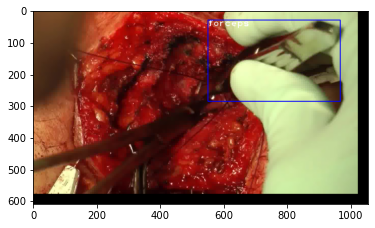

Bad


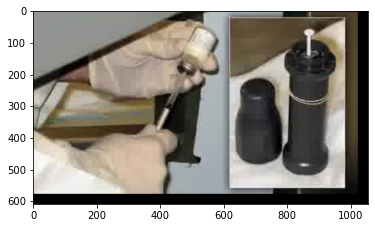

In [38]:
for filename in bad: 
    print("Bad") 
    displayFilenameAnnotations(filename) 

In [7]:

# Start by loading in json 
#Keeping track of what's there 


# Do the process, with a new CSVDataset built from raw data json 


# Then keep adding to the json on each iteration 